In [2]:
#!/usr/bin/python
import matplotlib
import os
import sys
import time
import math
import numpy as np
import pandas as pd
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
import importlib
import scimpute

home = os.environ['HOME']

/Users/rui/audrey/scImpute/translate/scimpute.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/rui/anaconda3/envs/py35/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/rui/anaconda3/envs/py35/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/rui/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/rui/anaconda3/envs/py35/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/rui/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/kernelapp.py", line

ImportError: No module named 'tensorflow'

In [ ]:
# READ CMD
print('''
usage: python -u combine_cell_gene_info.py gene_info_imputation cell_info_imputation input_data
select the best prediction for each gene
based on Gene_MSE(Y)/Gene_MSE(X)
''')

In [5]:
def gene_mse_nz_from_df(Y, X):
    '''
    get gene_mse from gene_expression_df (cell_row, with cell_id as index)
    X: input/ground-truth
    Y: imputation
    return a [gene, 1] pd.series with index of gene_ids 
    '''
    mse_df = pd.DataFrame(columns=['mse'])
    for i in range(X.shape[1]):
        mse_ = scimpute.mse_omega(Y.iloc[:, i], X.iloc[:, i])
        gene_name = X.columns[i]
        mse_df.loc[X.columns[i], 'mse']= mse_
    mse_df = mse_df.iloc[:, 0]
    print(mse_df.head(), '\n', mse_df.shape)
    return mse_df

In [6]:
def combine_gene_imputation_of_two_df(Y1, Y2, metric1, metric2, mode='smaller'):
    '''
    Y1, Y2 two imputation results (cell_row, df)
    Metric1, Metric2 ([num-gene, 1], df, same metircs for Y1 and Y2)
    select rows of Y1, Y2 into Y_combined
    mode: smaller/larger (being selected)
    Output in index/column order of Y1
    '''
    if mode == 'smaller':
        idx_better = metric1 < metric2
    elif mode == 'larger':
        idx_better = metric1> metric2
    else:
        raise Exception ('mode err')
#     try:
#         idx_better = idx_better.iloc[:, 0]  # df to series, important
#     except 'IndexingError':
#         pass
#     print('yg_better boolean series:\n', idx_better.head())

    Y_better_lst = [Y1.transpose()[idx_better], 
                      Y2.transpose()[~idx_better]] # list of frames
    Y_better = pd.concat(Y_better_lst)
    Y_better = Y_better.transpose()  # tr back
    Y_better = Y_better.loc[Y1.index, Y1.columns]  # get Y1 original order, just in case

#     print('Y1:\n', Y1.iloc[:5, :3])
#     print('Y2:\n', Y2.iloc[:5, :3])
#     print("metrics1:\n", metric1.iloc[:5])
#     print("metrics2:\n", metric2.iloc[:5])
#     print('Y_combined:\n', Y_better.iloc[:5, :3])
    
    return Y_better

# todo:
updated 05/16/2018: formatting

In [7]:
# arguments
sys.argv = ['combine_cell_gene_info.py',
            '../late5L_10k_nz10/step2/imputation.step2.hd5',  # gene_info imputation
           '../late5L_10k_nz10_cellInfo/step2/imputation.step2.hd5', # cell_info imputation
           home+'/data/cell_row/pbmc.g949_c10k.hd5']  # input

In [8]:
# READ DATA  (into cell_row, for consistancy with imputation.hd5)
file_gene = sys.argv[1]
file_cell = sys.argv[2]
file_input = sys.argv[3]

print("> READ DATA..")  # todo: add support for h5 sparse
Yg = scimpute.read_data_into_cell_row(file_gene, 'cell_row')
Yc = scimpute.read_data_into_cell_row(file_cell, 'gene_row')

X = scimpute.read_data_into_cell_row(file_input, 'cell_row')
X = scimpute.df_transformation(X, transformation='log')

print('aligning index to X')
Yg = Yg.reindex(X.index)
Yc = Yc.reindex(X.index)

# # TEST MODE OR NOT
# m = 100
# n = 10
# print('in test mode')
# Yc = Yc.iloc[0:m, 0:n]
# Yg = Yg.iloc[0:m, 0:n]
# X = X.iloc[0:m, 0:n]

# INPUT SUMMART
print("\n", 'DF in RAM:')
print('Yg.shape', Yg.shape, '\n', Yg.iloc[0:2, 0:2])
print('Yc.shape', Yc.shape, '\n', Yc.iloc[0:2, 0:2])
print('X.shape', X.shape, '\n', X.iloc[0:2, 0:2])

> READ DATA..
reading ../late5L_10k_nz10/step2/imputation.step2.hd5 as cell_row data frame
reading:  ../late5L_10k_nz10/step2/imputation.step2.hd5
(10000, 949)
                  ENSG00000187608  ENSG00000175756
Barcode                                           
GTAATATGGTGTTG-1         0.328230         0.344462
GAGCGCTGCTGACA-3         0.323499         0.329429
AAGGTCTGATTGGC-4         0.324200         0.310968
shape is (10000, 949)
nz_rate is 1.0
nz_count is 9489716

reading took 0.7 seconds
reading ../late5L_10k_nz10_cellInfo/step2/imputation.step2.hd5 as cell_row data frame
reading:  ../late5L_10k_nz10_cellInfo/step2/imputation.step2.hd5
(949, 10000)
Barcode          GTAATATGGTGTTG-1  GAGCGCTGCTGACA-3
ENSG00000187608          0.297540          0.327166
ENSG00000175756          0.306383          0.330167
ENSG00000242485          0.296451          0.320554
shape is (10000, 949)
nz_rate is 1.0
nz_count is 9489993

reading took 0.4 seconds
reading /mnt/lfs2/rui/data/cell_row/pbmc.g949_c

## COMBINE IMPUTATION

In [9]:
# COMBINE BY SMALLER MSE: cell_row assumed for DFs(Y and X)

# calculate mse
print('calculating mse_nz gene-info (Yg vs X):')
mse_Yg = gene_mse_nz_from_df(Yg, X)
print(mse_Yg.mean())

print('calculating mse_nz cell-info (Yc vs X):')
mse_Yc = gene_mse_nz_from_df(Yc, X)
print(mse_Yc.mean())

# combine by smaller mse
print('combining by smaller mse')
Y_mse_combined = combine_gene_imputation_of_two_df(Yg, Yc, mse_Yg, mse_Yc, mode='smaller')
scimpute.save_hd5(Y_mse_combined, 'imputation.combined_by_mse.hd5')

# calculate mse
print('calculating mse_nz combined (Y_mse_combined vs X):')
mse_Y_combined = gene_mse_nz_from_df(Y_mse_combined, X)
print('mse_nz between Y_combined and X:', mse_Y_combined.mean())

calculating mse_nz gene-info (Yg vs X):
ENSG00000187608     0.00237454
ENSG00000175756     0.00139513
ENSG00000242485     0.00102304
ENSG00000160075     0.00117013
ENSG00000162585    0.000951371
Name: mse, dtype: object 
 (949,)
0.005919465436872909
calculating mse_nz cell-info (Yc vs X):
ENSG00000187608    0.00233416
ENSG00000175756    0.00153116
ENSG00000242485    0.00106577
ENSG00000160075    0.00125735
ENSG00000162585    0.00107813
Name: mse, dtype: object 
 (949,)
0.006852611939237763
combining by smaller mse
savingimputation.combined_by_mse.hd5 took 0.3 seconds
calculating mse_nz combined (Y_mse_combined vs X):
ENSG00000187608     0.00233416
ENSG00000175756     0.00139513
ENSG00000242485     0.00102304
ENSG00000160075     0.00117013
ENSG00000162585    0.000951371
Name: mse, dtype: object 
 (949,)
mse_nz between Y_combined and X: 0.005912815375173008


In [10]:
# COMBINE BY LARGER GENE-STD: cell_row assumed for DFs(Y and X)

# calculate STD of genes in Y and X
print('calculating STD for Yg, Yc, and X')
x_std, yg_std = scimpute.nz_std(X, Yg)
x_std, yc_std = scimpute.nz_std(X, Yc)

# combine by smaller mse
Y_std_combined = combine_gene_imputation_of_two_df(Yg, Yc, yg_std, yc_std, mode='larger')
# scimpute.save_hd5(Y_std_combined, 'imputation.combined_by_sd.hd5') # not useful, not saved

# calculate mse
print('calculating mse_nz STD_combined vs X:')
mse_Y_combined2 = gene_mse_nz_from_df(Y_std_combined, X)
print('mse_nz between Y_combined and X:', mse_Y_combined2.mean())

calculating STD for Yg, Yc, and X
calculating mse_nz STD_combined vs X:
ENSG00000187608    0.00233416
ENSG00000175756    0.00153116
ENSG00000242485    0.00106577
ENSG00000160075    0.00125735
ENSG00000162585    0.00107813
Name: mse, dtype: object 
 (949,)
mse_nz between Y_combined and X: 0.006331757149961048


## HISTOGRAMS

In [11]:
# STD of genes in Y and X
print('calculating STD for Y and X')
x_std, yg_std = scimpute.nz_std(X, Yg)
x_std, yc_std = scimpute.nz_std(X, Yc)

std_df = pd.DataFrame(data=list(zip(x_std, yg_std[x_std.index], yc_std[x_std.index],
                                    yg_std/x_std, yc_std/x_std, yg_std/yc_std)),
                      index=x_std.index,
                      columns=['X_std', 'Yg_std', 'Yc_std', 
                               'Yg_X_ratio', 'Yc_X_ratio', 'Yg_Yc_ratio'])
std_df.head()
std_df.to_csv('std_df.csv')
print('std_df.csv saved')

calculating STD for Y and X
std_df.csv saved


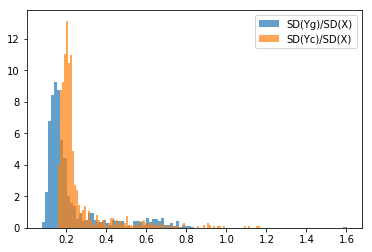

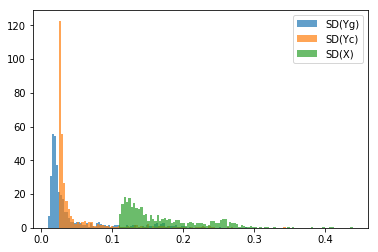

In [19]:
# HIST OF STD
fig, ax = plt.subplots()

ax.hist(std_df.loc[:, 'Yg_X_ratio'], bins=100, label='SD(Yg)/SD(X)', density=True, alpha=0.7)
ax.hist(std_df.loc[:, 'Yc_X_ratio'], bins=100, label='SD(Yc)/SD(X)', density=True, alpha=0.7)
ax.legend()
fig.savefig('hist_std_ratio.png', bbox_inches='tight')
plt.show()
plt.close()


fig, ax = plt.subplots()
ax.hist(std_df.loc[:, 'Yg_std'], bins=100, label='SD(Yg)', density=True, alpha=0.7)
ax.hist(std_df.loc[:, 'Yc_std'], bins=100, label='SD(Yc)', density=True, alpha=0.7)
ax.hist(std_df.loc[:, 'X_std'], bins=100, label='SD(X)', density=True, alpha=0.7)
ax.legend()
plt.show()
fig.savefig('hist_std.png', bbox_inches='tight')
plt.close()

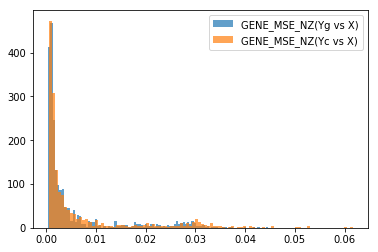

In [22]:
# HIST OF MSE
fig, ax = plt.subplots()
ax.hist(mse_Yg.values.astype('float'), bins=100, label='GENE_MSE_NZ(Yg vs X)', density=True, alpha=0.7)
ax.hist(mse_Yc.values.astype('float'), bins=100, label='GENE_MSE_NZ(Yc vs X)', density=True, alpha=0.7)
ax.legend()
plt.show()
fig.savefig('hist_gene_mse.png', bbox_inches='tight')
plt.close()

## Plot top genes diff in gene-info and cell-info imputation

In [14]:
# TOP GENES DIFFERENT IN Yc and Yg
num_genes = 10
_ = std_df.sort_values(by='Yg_Yc_ratio', ascending=False).head(num_genes)
print('## sort by Yg_Yc_ratio (Yg better):\n', _)
Yg_better_genes = _.index

_ = std_df.sort_values(by='Yg_Yc_ratio', ascending=True).head(num_genes)
print('## sort by Yg_Yc_ratio (Yc_better):\n', _)
Yc_better_genes = _.index

## sort by Yg_Yc_ratio (Yg better):
                     X_std    Yg_std    Yc_std  Yg_X_ratio  Yc_X_ratio  \
ENSG00000254709  0.112234  0.179613  0.027981    1.600347    0.249309   
ENSG00000105369  0.165778  0.100223  0.036774    0.604563    0.221830   
ENSG00000090382  0.189197  0.143364  0.066769    0.757748    0.352910   
ENSG00000143546  0.150768  0.110043  0.054293    0.729882    0.360111   
ENSG00000172116  0.168268  0.068544  0.033827    0.407352    0.201033   
ENSG00000026025  0.275544  0.086288  0.043738    0.313154    0.158734   
ENSG00000227507  0.380869  0.196391  0.106487    0.515638    0.279590   
ENSG00000007312  0.162493  0.073230  0.039895    0.450663    0.245518   
ENSG00000132965  0.139339  0.045886  0.026509    0.329311    0.190249   
ENSG00000101439  0.239499  0.167997  0.097113    0.701453    0.405484   

                 Yg_Yc_ratio  
ENSG00000254709     6.419125  
ENSG00000105369     2.725343  
ENSG00000090382     2.147146  
ENSG00000143546     2.026829  
ENSG

In [15]:
## PLT TOP GENES
gene_plt_dir = 'gene_feature_better_genes'

for gene in Yg_better_genes:
    print(gene)
    scimpute.scatterplot2(X.loc[:, gene],  Yg.loc[:,gene],
                          range='same',
                          title = gene + ' (Gene-feature))',
                          xlabel='Ground Truth, SD(Y)/SD(X):' + str(round(std_df.loc[gene,'Yg_X_ratio'], 3)),
                          ylabel='Imputation (Gene-feature)',
                          dir=gene_plt_dir)
    scimpute.scatterplot2(X.loc[:, gene],  Yc.loc[:,gene],
                          range='same',
                          title = gene + ' (Cell-feature))',
                          xlabel='Ground Truth, SD(Y)/SD(X):' + str(round(std_df.loc[gene,'Yc_X_ratio'], 3)),
                          ylabel='Imputation (Cell-feature)',
                          dir=gene_plt_dir)

ENSG00000254709
ENSG00000105369
ENSG00000090382
ENSG00000143546
ENSG00000172116
ENSG00000026025
ENSG00000227507
ENSG00000007312
ENSG00000132965
ENSG00000101439


In [14]:
## PLT TOP GENES
gene_plt_dir = 'cell_feature_better_genes'

for gene in Yc_better_genes:
    print(gene)
    scimpute.scatterplot2(X.loc[:, gene],  Yg.loc[:,gene],
                          range='same',
                          title = gene + ' (Gene-feature))',
                          xlabel='Ground Truth, SD(Y)/SD(X):' + str(round(std_df.loc[gene,'Yg_X_ratio'], 3)),
                          ylabel='Imputation (Gene-feature)',
                          dir=gene_plt_dir)
    scimpute.scatterplot2(X.loc[:, gene],  Yc.loc[:,gene],
                          range='same',
                          title = gene + ' (Cell-feature))',
                          xlabel='Ground Truth, SD(Y)/SD(X):' + str(round(std_df.loc[gene,'Yc_X_ratio'], 3)),
                          ylabel='Imputation (Cell-feature)',
                          dir=gene_plt_dir)

ENSG00000187145
ENSG00000136950
ENSG00000185187
ENSG00000167085
ENSG00000172428
ENSG00000130706
ENSG00000183726
ENSG00000120913
ENSG00000116171
ENSG00000187051


In [15]:
!sh result_analysis.sh